In [1]:
!pip install avalanche-lib==0.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.4/532.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.8/452.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=c2727b468718

In [2]:
# importing pytorch and SGD optimizer
import torch
import torchvision
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
# importing splitmnist benchmark
from avalanche.benchmarks.classic import SplitCIFAR10
# importing models and plugins and evaluation metrics
# using simpleMLP and PNN as a base models
from avalanche.training.plugins import EarlyStoppingPlugin
from avalanche.models import SimpleMLP,PNN,PNNLayer,SimpleCNN,PNNColumn
from avalanche.training.supervised import Naive, Replay, GDumb, LwF , EWC , CWRStar, PNNStrategy,GEM   # and many more!
# the way we can save the evaluation log in txt for other formats
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger,TextLogger
from avalanche.evaluation.metrics import accuracy_metrics,\
    cpu_usage_metrics,forward_transfer_metrics,bwt_metrics,\
    ram_usage_metrics, timing_metrics,\
    StreamForwardTransfer,StreamBWT
import matplotlib.pyplot as plt
import numpy as np
import statistics
import os

#**Model creating and preprocessing part:**


In [3]:
from google.colab import drive
drive.mount('/drive')
!ls/drive/my\drive

Mounted at /drive
/bin/bash: line 1: ls/drive/mydrive: No such file or directory


In [ ]:
# loading the benchmark and considering 5 experiences
split_mnist = SplitCIFAR10(n_experiences=5,return_task_id=True, seed=13)
print('--- Task labels:')
print(split_mnist.task_labels)

loggers = []

# log to text file
loggers.append(TextLogger(open('naive_log.txt', 'a')))

# print to stdout
loggers.append(InteractiveLogger())


# loading the model
# there is a big problem while we are using cifar dataset and it's that the shape of the data.
# unless mnist cifar is colored data and we have 3 dimensions. then we need to define the
# shape of the input and number of hidden channels here.
model = SimpleMLP(num_classes=10,input_size=32*32*3, hidden_size=256)
# defining the optimizer with constant parameters
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
# defining the loss function
criterion = CrossEntropyLoss()
# here the evaluation plugin defined
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True),
    bwt_metrics(experience=True),
    forward_transfer_metrics(experience=True),
    timing_metrics(experience=True,stream=True),
    cpu_usage_metrics(experience=True,stream=True),
    ram_usage_metrics( experience=True, stream=True),
    StreamForwardTransfer(),
    StreamBWT(),

        loggers=loggers,
        collect_all=False,
        strict_checks=False
)




100%|██████████| 170498071/170498071 [00:01<00:00, 99121548.96it/s] 


Extracting /root/.avalanche/data/cifar10/cifar-10-python.tar.gz to /root/.avalanche/data/cifar10
Files already downloaded and verified
--- Task labels:
[[0], [1], [2], [3], [4]]


##**Naive aproach:**

In [ ]:
"""
We are defining Naive strategy. here our model is SimpleMLP and the optimizer is SGD.
train_mb_size is training mini-batch size and considered 100 samples. this means we train the model with 100 samples, compute the SGD
and then train the model with the following 100 samples. if we select a higher value for batch, the training phase finishes
early but maybe our model doesn't converge to the global minimum. This is a hyperparameter and must be tuned during the training phase.
for simplicity, we are considering the constant value for it.

The next parameter is train_epoch, this is the number of training iterations on the same data. we considered it
as a fixed value 10 epoches.eval_mb_size is batch size for evaluation part.

In all the strategies we are evaluating our model based on different metrics and these metrics saved in eval_plugin.
Here the eval_every parameter set to 1. the frequency of the calls to eval inside the training loop. -1 disables the
evaluation. 0 means eval is called only at the end of the learning experience. Values >0 mean that eval is called every eval_every
epochs and at the end of the learning experience.

finally we set plugins that we need. here just we are using early stopping. We are training our model in fixed number of epoches.
for preventing overfitting we are using earlystopping with patience=3.
this means if in the next 3 iterations, the training loss doesn't decrease then stop the training.
"""
cl_strategy = Naive(
    model, optimizer,
    CrossEntropyLoss(), train_mb_size=512, train_epochs=10, eval_mb_size=512,
    evaluator=eval_plugin,eval_every=1,
     plugins=[EarlyStoppingPlugin(patience=3, val_stream_name='train')])

In [ ]:
# saving the results of evaluation.
results = []

for experience in split_mnist.train_stream:
    # train returns a dictionary which contains all the metric values
    print("Start of experience::::: ", experience.current_experience)
    print("Current Classes::::: ", experience.classes_in_this_experience)
    cl_strategy.train(experience,eval_streams=[split_mnist.test_stream])
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(experience))
    print('Validation on test sets are completed')

Start of experience:::::  0
Current Classes:::::  [8, 5]
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 4/4 [00:01<00:00,  2.15it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 62.2964
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 1208.4414
	Time_Exp/eval_phase/test_stream/Task000/Exp000 = 1.9267
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0480
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 4/4 [00:01<00:00,  2.45it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task001/Exp001 = 72.7359
	MaxRAMUsage_Experience/eval_phase/test_stream/Task001/Exp001 = 1209.1992
	Time_Exp/eval_phase/test_stream/Task001/Exp001 = 1.6221
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.1400
-- Starting eval on experience 2 (Task 

# **Replay**

In [ ]:
# loading the benchmark and considering 5 experiences
split_mnist = SplitCIFAR10(n_experiences=5,return_task_id=True, seed=13)
print('--- Task labels:')
print(split_mnist.task_labels)

loggers = []

# log to text file
loggers.append(TextLogger(open('replay_log.txt', 'a')))

# print to stdout
loggers.append(InteractiveLogger())


# loading the model
model = SimpleMLP(num_classes=10,input_size=32*32*3, hidden_size=256)
# defining the optimizer with constant parameters
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
# defining the loss function
criterion = CrossEntropyLoss()
# here the evaluation plugin defined
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True),
    bwt_metrics(experience=True),
    forward_transfer_metrics(experience=True),
    timing_metrics(experience=True,stream=True),
    cpu_usage_metrics(experience=True,stream=True),
    ram_usage_metrics( experience=True, stream=True),
    StreamForwardTransfer(),
    StreamBWT(),

        loggers=loggers,
        collect_all=False,
        strict_checks=False
)

cl_strategy = Replay(
    model, optimizer,
    CrossEntropyLoss(), train_mb_size=512, train_epochs=10, eval_mb_size=512,
    evaluator=eval_plugin,eval_every=1,
     plugins=[EarlyStoppingPlugin(patience=3, val_stream_name='train')])


Files already downloaded and verified
Files already downloaded and verified
--- Task labels:
[[0], [1], [2], [3], [4]]


In [ ]:
# saving the results of evaluation.
results = []

for experience in split_mnist.train_stream:
    # train returns a dictionary which contains all the metric values
    print("Start of experience::::: ", experience.current_experience)
    print("Current Classes::::: ", experience.classes_in_this_experience)
    cl_strategy.train(experience,eval_streams=[split_mnist.test_stream])
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(experience))
    print('Validation on test sets are completed')

Start of experience:::::  0
Current Classes:::::  [8, 5]
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 4/4 [00:01<00:00,  3.92it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 94.8170
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 1363.7148
	Time_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0234
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0480
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 4/4 [00:01<00:00,  3.65it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task001/Exp001 = 97.7974
	MaxRAMUsage_Experience/eval_phase/test_stream/Task001/Exp001 = 1363.7148
	Time_Exp/eval_phase/test_stream/Task001/Exp001 = 1.0948
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.1400
-- Starting eval on experience 2 (Task 

# **GDumb**

In [ ]:
# loading the benchmark and considering 5 experiences
split_mnist = SplitCIFAR10(n_experiences=5,return_task_id=True, seed=13)
print('--- Task labels:')
print(split_mnist.task_labels)

loggers = []

# log to text file
loggers.append(TextLogger(open('GDumb_log.txt', 'a')))

# print to stdout
loggers.append(InteractiveLogger())


# loading the model
model = SimpleMLP(num_classes=10,input_size=32*32*3, hidden_size=256)
# defining the optimizer with constant parameters
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
# defining the loss function
criterion = CrossEntropyLoss()
# here the evaluation plugin defined
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True),
    bwt_metrics(experience=True),
    forward_transfer_metrics(experience=True),
    timing_metrics(experience=True,stream=True),
    cpu_usage_metrics(experience=True,stream=True),
    ram_usage_metrics( experience=True, stream=True),
    StreamForwardTransfer(),
    StreamBWT(),

        loggers=loggers,
        collect_all=False,
        strict_checks=False
)
cl_strategy = GDumb(
    model, optimizer,
    CrossEntropyLoss(), train_mb_size=512, train_epochs=10, eval_mb_size=512,
    evaluator=eval_plugin,eval_every=1,
     plugins=[EarlyStoppingPlugin(patience=3, val_stream_name='train')])


Files already downloaded and verified
Files already downloaded and verified
--- Task labels:
[[0], [1], [2], [3], [4]]


In [ ]:
# saving the results of evaluation.
results = []

for experience in split_mnist.train_stream:
    # train returns a dictionary which contains all the metric values
    print("Start of experience::::: ", experience.current_experience)
    print("Current Classes::::: ", experience.classes_in_this_experience)
    cl_strategy.train(experience,eval_streams=[split_mnist.test_stream])
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(experience))
    print('Validation on test sets are completed')

Start of experience:::::  0
Current Classes:::::  [8, 5]
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 4/4 [00:00<00:00,  4.83it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 99.0622
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	Time_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8282
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0480
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 4/4 [00:00<00:00,  4.86it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task001/Exp001 = 99.0635
	MaxRAMUsage_Experience/eval_phase/test_stream/Task001/Exp001 = 1362.8008
	Time_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8284
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.1400
-- Starting eval on experience 2 (Task 2) from 

# **LwF**

In [ ]:
# loading the benchmark and considering 5 experiences
split_mnist = SplitCIFAR10(n_experiences=5,return_task_id=True, seed=13)
print('--- Task labels:')
print(split_mnist.task_labels)

loggers = []

# log to text file
loggers.append(TextLogger(open('LwF_log.txt', 'a')))

# print to stdout
loggers.append(InteractiveLogger())


# loading the model
model = SimpleMLP(num_classes=10,input_size=32*32*3, hidden_size=256)
# defining the optimizer with constant parameters
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
# defining the loss function
criterion = CrossEntropyLoss()
# here the evaluation plugin defined
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True),
    bwt_metrics(experience=True),
    forward_transfer_metrics(experience=True),
    timing_metrics(experience=True,stream=True),
    cpu_usage_metrics(experience=True,stream=True),
    ram_usage_metrics( experience=True, stream=True),
    StreamForwardTransfer(),
    StreamBWT(),

        loggers=loggers,
        collect_all=False,
        strict_checks=False
)
cl_strategy = LwF(
    model, optimizer,
    CrossEntropyLoss(),alpha = 0.3, temperature= 0.5, train_mb_size=512, train_epochs=10, eval_mb_size=512,
    evaluator=eval_plugin,eval_every=1,
     plugins=[EarlyStoppingPlugin(patience=3, val_stream_name='train')])


Files already downloaded and verified
Files already downloaded and verified
--- Task labels:
[[0], [1], [2], [3], [4]]


In [ ]:
# saving the results of evaluation.
results = []

for experience in split_mnist.train_stream:
    # train returns a dictionary which contains all the metric values
    print("Start of experience::::: ", experience.current_experience)
    print("Current Classes::::: ", experience.classes_in_this_experience)
    cl_strategy.train(experience,eval_streams=[split_mnist.test_stream])
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(experience))
    print('Validation on test sets are completed')

Start of experience:::::  0
Current Classes:::::  [8, 5]
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 4/4 [00:00<00:00,  5.06it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 98.6344
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	Time_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7931
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0480
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 4/4 [00:00<00:00,  4.85it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task001/Exp001 = 98.3966
	MaxRAMUsage_Experience/eval_phase/test_stream/Task001/Exp001 = 1363.6133
	Time_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8232
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.1400
-- Starting eval on experience 2 (Task 2) from 

# **EWC**

In [ ]:
# loading the benchmark and considering 5 experiences
split_mnist = SplitCIFAR10(n_experiences=5,return_task_id=True, seed=13)
print('--- Task labels:')
print(split_mnist.task_labels)

loggers = []

# log to text file
loggers.append(TextLogger(open('EWC_log.txt', 'a')))

# print to stdout
loggers.append(InteractiveLogger())


# loading the model
model = SimpleMLP(num_classes=10,input_size=32*32*3, hidden_size=256)
# defining the optimizer with constant parameters
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
# defining the loss function
criterion = CrossEntropyLoss()
# here the evaluation plugin defined
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True),
    bwt_metrics(experience=True),
    forward_transfer_metrics(experience=True),
    timing_metrics(experience=True,stream=True),
    cpu_usage_metrics(experience=True,stream=True),
    ram_usage_metrics( experience=True, stream=True),
    StreamForwardTransfer(),
    StreamBWT(),

        loggers=loggers,
        collect_all=False,
        strict_checks=False
)

cl_strategy = EWC(
    model, optimizer,
    CrossEntropyLoss(),ewc_lambda=0.4, train_mb_size=512, train_epochs=10, eval_mb_size=512,
    evaluator=eval_plugin,eval_every=1,
     plugins=[EarlyStoppingPlugin(patience=3, val_stream_name='train')])


Files already downloaded and verified
Files already downloaded and verified
--- Task labels:
[[0], [1], [2], [3], [4]]


In [ ]:
# saving the results of evaluation.
results = []

for experience in split_mnist.train_stream:
    # train returns a dictionary which contains all the metric values
    print("Start of experience::::: ", experience.current_experience)
    print("Current Classes::::: ", experience.classes_in_this_experience)
    cl_strategy.train(experience,eval_streams=[split_mnist.test_stream])
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(experience))
    print('Validation on test sets are completed')

Start of experience:::::  0
Current Classes:::::  [8, 5]
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 4/4 [00:00<00:00,  4.82it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 100.0851
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	Time_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8295
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0480
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 4/4 [00:00<00:00,  4.29it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task001/Exp001 = 98.0330
	MaxRAMUsage_Experience/eval_phase/test_stream/Task001/Exp001 = 1391.1016
	Time_Exp/eval_phase/test_stream/Task001/Exp001 = 0.9285
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.1400
-- Starting eval on experience 2 (Task 2) from

# **CWRStar**

In [ ]:
# loading the benchmark and considering 5 experiences
split_mnist = SplitCIFAR10(n_experiences=5,return_task_id=True, seed=13)
print('--- Task labels:')
print(split_mnist.task_labels)

loggers = []

# log to text file
loggers.append(TextLogger(open('CWRStar_log.txt', 'a')))

# print to stdout
loggers.append(InteractiveLogger())


# loading the model
model = SimpleMLP(num_classes=10,input_size=32*32*3, hidden_size=256)
# defining the optimizer with constant parameters
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
# defining the loss function
criterion = CrossEntropyLoss()
# here the evaluation plugin defined
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True),
    bwt_metrics(experience=True),
    forward_transfer_metrics(experience=True),
    timing_metrics(experience=True,stream=True),
    cpu_usage_metrics(experience=True,stream=True),
    ram_usage_metrics( experience=True, stream=True),
    StreamForwardTransfer(),
    StreamBWT(),

        loggers=loggers,
        collect_all=False,
        strict_checks=False
)

cl_strategy = CWRStar(
    model, optimizer,
    CrossEntropyLoss(),cwr_layer_name=None, train_mb_size=512, train_epochs=10, eval_mb_size=512,
    evaluator=eval_plugin,eval_every=1,
     plugins=[EarlyStoppingPlugin(patience=3, val_stream_name='train')])


Files already downloaded and verified
Files already downloaded and verified
--- Task labels:
[[0], [1], [2], [3], [4]]


In [ ]:
# saving the results of evaluation.
results = []

for experience in split_mnist.train_stream:
    # train returns a dictionary which contains all the metric values
    print("Start of experience::::: ", experience.current_experience)
    print("Current Classes::::: ", experience.classes_in_this_experience)
    cl_strategy.train(experience,eval_streams=[split_mnist.test_stream])
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(experience))
    print('Validation on test sets are completed')

Start of experience:::::  0
Current Classes:::::  [8, 5]
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 4/4 [00:00<00:00,  4.78it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 98.2103
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	Time_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8350
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0480
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 4/4 [00:00<00:00,  4.84it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task001/Exp001 = 98.1843
	MaxRAMUsage_Experience/eval_phase/test_stream/Task001/Exp001 = 1450.6641
	Time_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8255
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.1400
-- Starting eval on experience 2 (Task 2) from 

# **PNNStrategy**

In [ ]:
# loading the benchmark and considering 5 experiences
split_mnist = SplitCIFAR10(n_experiences=5,return_task_id=True, seed=13)
print('--- Task labels:')
print(split_mnist.task_labels)

loggers = []

# log to text file
loggers.append(TextLogger(open('PNNstrategy_log.txt', 'a')))

# print to stdout
loggers.append(InteractiveLogger())


# loading the model
model = PNN(in_features=32*32*3, hidden_features_per_column=100)

# defining the optimizer with constant parameters
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
# defining the loss function
criterion = CrossEntropyLoss()
# here the evaluation plugin defined
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True),
    bwt_metrics(experience=True),
    forward_transfer_metrics(experience=True),
    timing_metrics(experience=True,stream=True),
    cpu_usage_metrics(experience=True,stream=True),
    ram_usage_metrics( experience=True, stream=True),
    StreamForwardTransfer(),
    StreamBWT(),

        loggers=loggers,
        collect_all=False,
        strict_checks=False
)


cl_strategy = PNNStrategy(
    model, optimizer,
    CrossEntropyLoss(), train_mb_size=32, train_epochs=10, eval_mb_size=512,
    evaluator=eval_plugin,eval_every=1,
     plugins=[EarlyStoppingPlugin(patience=3, val_stream_name='train')])


Files already downloaded and verified
Files already downloaded and verified
--- Task labels:
[[0], [1], [2], [3], [4]]


In [ ]:
# saving the results of evaluation.
results = []

for experience in split_mnist.train_stream:
    # train returns a dictionary which contains all the metric values
    print("Start of experience::::: ", experience.current_experience)
    print("Current Classes::::: ", experience.classes_in_this_experience)
    cl_strategy.train(experience,eval_streams=[split_mnist.test_stream])
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(experience))
    print('Validation on test sets are completed')

Start of experience:::::  0
Current Classes:::::  [8, 5]
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 4/4 [00:00<00:00,  4.86it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 98.3969
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	Time_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8232
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0000
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 4/4 [00:00<00:00,  4.55it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task001/Exp001 = 100.1086
	MaxRAMUsage_Experience/eval_phase/test_stream/Task001/Exp001 = 1451.2148
	Time_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8792
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.0000
-- Starting eval on experience 2 (Task 2) from

# GEM

In [ ]:
# loading the benchmark and considering 5 experiences
split_mnist = SplitCIFAR10(n_experiences=5,return_task_id=True, seed=13)
print('--- Task labels:')
print(split_mnist.task_labels)

loggers = []

# log to text file
loggers.append(TextLogger(open('GEM_log.txt', 'a')))

# print to stdout
loggers.append(InteractiveLogger())


# loading the model
model = SimpleMLP(num_classes=10,input_size=32*32*3, hidden_size=256)
# defining the optimizer with constant parameters
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
# defining the loss function
criterion = CrossEntropyLoss()
# here the evaluation plugin defined
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True),
    bwt_metrics(experience=True),
    forward_transfer_metrics(experience=True),
    timing_metrics(experience=True,stream=True),
    cpu_usage_metrics(experience=True,stream=True),
    ram_usage_metrics( experience=True, stream=True),
    StreamForwardTransfer(),
    StreamBWT(),

        loggers=loggers,
        collect_all=False,
        strict_checks=False
)


# GEM requires patterns_per_exp. here we put a constant value but this should be tuned in training phase.
# patterns_per_exp – number of patterns per experience in the memory
cl_strategy = GEM(
    model, optimizer,
    CrossEntropyLoss(), train_mb_size=512, train_epochs=10, eval_mb_size=512,
    evaluator=eval_plugin,eval_every=1,patterns_per_exp = 100,
     plugins=[EarlyStoppingPlugin(patience=3, val_stream_name='train')])


Files already downloaded and verified
Files already downloaded and verified
--- Task labels:
[[0], [1], [2], [3], [4]]


In [ ]:
# saving the results of evaluation.
results = []

for experience in split_mnist.train_stream:
    # train returns a dictionary which contains all the metric values
    print("Start of experience::::: ", experience.current_experience)
    print("Current Classes::::: ", experience.classes_in_this_experience)
    cl_strategy.train(experience,eval_streams=[split_mnist.test_stream])
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(experience))
    print('Validation on test sets are completed')

Start of experience:::::  0
Current Classes:::::  [8, 5]
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 4/4 [00:00<00:00,  4.87it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 98.6059
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	Time_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8217
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0480
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 4/4 [00:01<00:00,  3.41it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task001/Exp001 = 94.3743
	MaxRAMUsage_Experience/eval_phase/test_stream/Task001/Exp001 = 1452.6328
	Time_Exp/eval_phase/test_stream/Task001/Exp001 = 1.1655
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.1400
-- Starting eval on experience 2 (Task 2) from 

# **Evaluation**
### Now is the time to evaluate strategies based on different criteria. We have 9 strategies to compare. First of all, we compare strategies based on CPU and RAM usage and the amount of time that takes one training procedure finishes. Then we go to the most important part to evaluate strategies based on ACC, BWT, and FWT.

**A quick recap about algorithms:**

**Naive:** This is a single-task learning strategy. This means while new experience comes it doesn't consider previous ones. Then we expect to have catastrophic forgetting here.

**Replay:** Mix old experiences samples with new ones and train the model.

**GDUMB:** Aims to address the catastrophic forgetting problem by maintaining an unbiased memory buffer of previously learned tasks and using it to update the neural network weights during training on new tasks.

**LWF:** The LWF strategy works by training the neural network on a combination of the current task and a subset of previously learned tasks. During training, the loss function is modified to include a distillation term, which encourages the neural network to produce similar outputs for both the current task and the previously learned tasks.

**EWC:** This adds a regularization term to penalize changes on important parameters of previous tasks. in this way, we can deal with catastrophic forgetting by remembering the past task parameters.

**CWRstar:** The CWRstar strategy works by modifying the loss function used for training the neural network. During training on a new task, the CWRstar algorithm adds a penalty term to the loss function that encourages the neural network to assign similar weights to the classes in the new task as in the previous tasks. This helps to prevent the neural network from overfitting to the new task and forgetting the previous tasks.

**PNN:** The PNN strategy works by modifying the architecture of the neural network. During training on a new task, the PNN algorithm adds a new neural network module that is trained to perform the new task while reusing the knowledge stored in the previous modules. The outputs of the previous modules are used as inputs to the new module, allowing it to incorporate the information learned from the previous tasks. Main focus on the forward transfer and re-use of previously acquired representational power

GEM: is like a mix of replay and regularization strategies. During training on a new task, the GEM algorithm stores a set of examples from the new task in the memory buffer and constrains the updates to the neural network weights to be consistent with the predictions made on the examples in the memory buffer.


**Comparison between strategies:**

In [4]:

directory = "/drive/My Drive/Colab Notebooks/SDA project/mnist"
# Define a list of filenames to read
filenames = ["naive_log.txt", "replay_log.txt", "EWC_log.txt", "LwF_log.txt", "GDumb_log.txt", "CWRstar_log.txt", "PNNStrategy_log.txt", "GEM_log.txt"]
# Loop over each filename and read its contents
time = []
CPU = []
RAM = []
FWT = []
BWT = []
for filename in filenames:
  filepath = os.path.join(directory, filename)
  with open(filepath, "r") as f:
      log_contents = f.read()
      # Do something with the file contents
      lines = log_contents.split('\n')
      filtered_list = [elem for elem in lines if '--' not in elem]
      filtered_list = [elem for elem in filtered_list if '>' not in elem]
      filtered_list = [elem for elem in filtered_list if 'Epoch' not in elem]
      filtered_list = [elem for elem in filtered_list if elem]

      key_value_pairs = [elem.split('=') for elem in filtered_list]

      # Use a dictionary comprehension to create a dictionary from the key-value pairs
      my_dict = {pair[0]: (pair[1]) for pair in key_value_pairs}

      # Loop through each line of the log file
      search_string = 'Time_Stream/eval_phase/train_stream'
      # Use a list comprehension to extract the values for keys that contain the search string
      Time_usage = [float(my_dict[key]) for key in my_dict if search_string in key]
      time.append(Time_usage)

      search_string = 'CPUUsage_Stream/eval_phase/train_stream'
      CPU_usage = [float(my_dict[key]) for key in my_dict if search_string in key]
      CPU.append(CPU_usage)

      search_string = 'MaxRAMUsage_Stream/eval_phase/train_stream'
      RAM_usage = [float(my_dict[key]) for key in my_dict if search_string in key]
      RAM.append(RAM_usage)

      search_string = 'StreamForwardTransfer/eval_phase/test_stream'
      f_transform = [float(my_dict[key]) for key in my_dict if search_string in key]
      FWT.append(f_transform)

      search_string = 'StreamBWT/eval_phase/test_stream'
      b_transform = [float(my_dict[key]) for key in my_dict if search_string in key]
      BWT.append(b_transform)

**Running time:**

In [5]:
categories = ['Naive','Replay','EWC', 'LwF', 'GDumb','CWRStar','PNN\nstrategy','GEM']

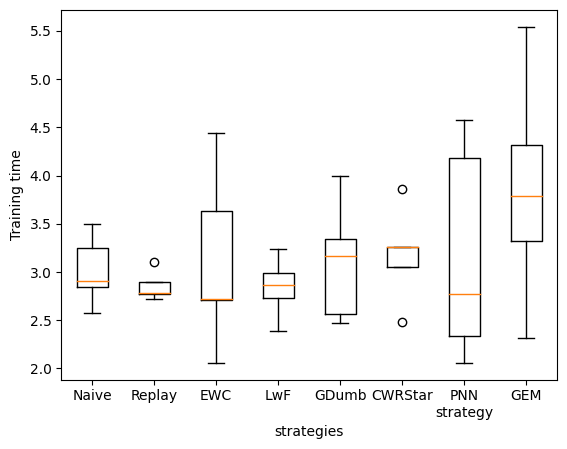

In [6]:
fig, ax = plt.subplots()
ax.boxplot(time)
# set the labels for the x-axis and y-axis
ax.set_xticklabels(categories)
ax.set_ylabel('Training time')
ax.set_xlabel('strategies')
# show the plot
plt.show()

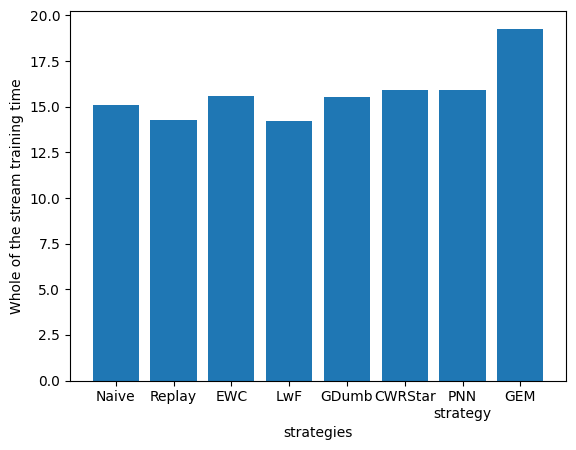

In [7]:
row_sums = [sum(row) for row in time]
plt.bar(categories, row_sums)
plt.ylabel('Whole of the stream training time')
plt.xlabel('strategies')
plt.show()

The most important thing here is that we are implementing these strategies with simpleMLP model and we can't see any major difference between different strategies. It is clear that EWC and LWF require the storage of a lot of parameters including model parameters and regularization term parameters, then it can be computationally expensive and takes a bit more time in training. CWRstar also is like the regularization and requires a dual memory system approach, one for better plasticity, and one for memory consolidation and it takes a bit longer in some cases.
Methods like replay and GDUMB doesn't take so much because it just uses previous task samples without modifying the architecture or loss function, but if we select a large number of previous samples in a new task then it can increase the running time.
In general PNN strategies are using previously extracted knowledge for the next layers and this way significant growth in the parameter space could happen. then if we use a large model we can expect a long training time.
Naive model is using the pure model without adding new parameters, by doing so these strategies are not a big deal and don't take so much time.
GEM is like the combination of replay and regularization methods, then approximately the running time is like these methods.

**CPU usage**

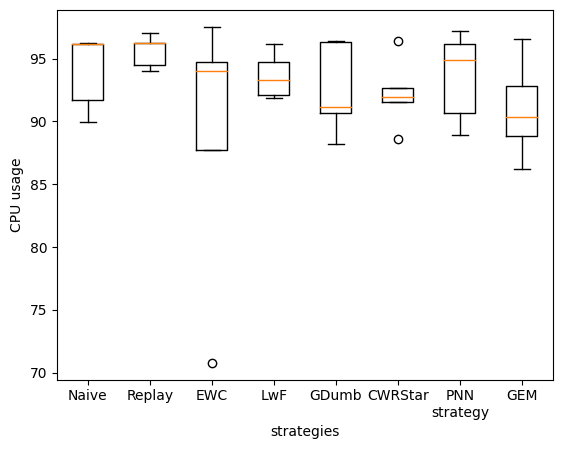

In [8]:
fig, ax = plt.subplots()
ax.boxplot(CPU)
# set the labels for the x-axis and y-axis
ax.set_xticklabels(categories)
plt.ylabel('CPU usage')
plt.xlabel('strategies')
# show the plot
plt.show()

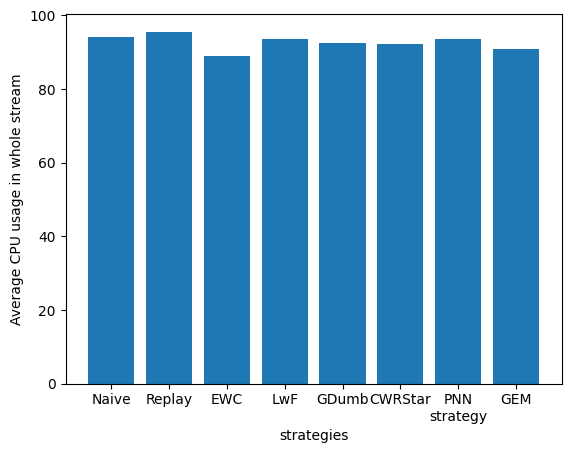

In [9]:
row_sums = [statistics.mean(row) for row in CPU]
plt.bar(categories, row_sums)
plt.ylabel('Average CPU usage in whole stream')
plt.xlabel('strategies')
plt.show()



The naive approach uses a single model for each experience then it is reasonable to have less CPU usage. Replay and LwF strategy uses previous samples in new tasks and it's computationally a bit more expensive than Naive methods. GDUMB and EWC methods are using penalty terms in loss function it's computationally expensive but is less than replay methods. CWRstar is expensive in terms of memory because of using dual memory but as we see the CPU usage is pretty much smaller than other methods. PNN method uses previous knowledge, then they have more computations. finally, the GEM method as we know is the combination of both the replay and regularization methods, it has pretty high CPU usage.bold text

**RAM usage**

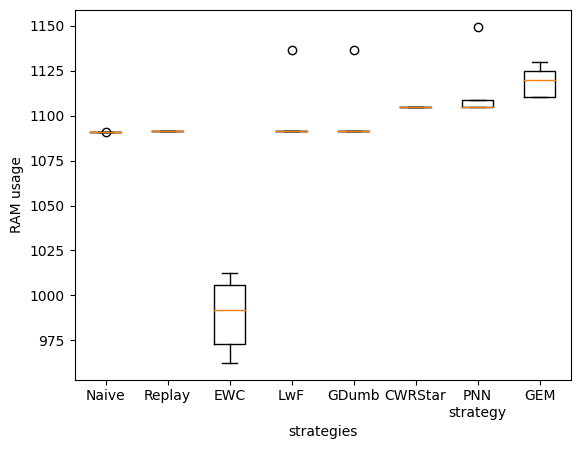

In [10]:
fig, ax = plt.subplots()
ax.boxplot(RAM)
# set the labels for the x-axis and y-axis
ax.set_xticklabels(categories)
ax.set_ylabel('RAM usage')
ax.set_xlabel('strategies')
# show the plot
plt.show()

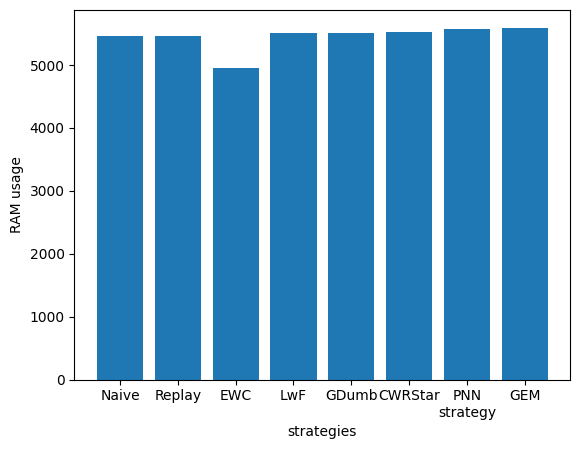

In [11]:
row_sums = [sum(row) for row in RAM]
plt.bar(categories, row_sums)
plt.ylabel('RAM usage')
plt.xlabel('strategies')
plt.show()

As we mentioned in previous steps, models based on replay and naive strategies just use the samples for training without any adding parameters to the loss function. This way these have less RAM usage. in the above chart we can see Naive, Replay, and GDUMB have less ram usage than others. LwF only stores the knowledge from the previous task and transfers it to the current task, whereas EWC stores the importance of each weight for every task, which can lead to a significant increase in memory usage. PNN algorithm adds a new neural network module that is trained to perform the new task while reusing the knowledge stored in the previous modules. The CWRstar strategy works by modifying the loss function used for training the neural network. By doing so, these two methods have more RAM usage usually. GEM is a hybrid method and as it benefits the regularization approach it consumes more RAM.




**ACC, plasticity, and catastrophic comparison**

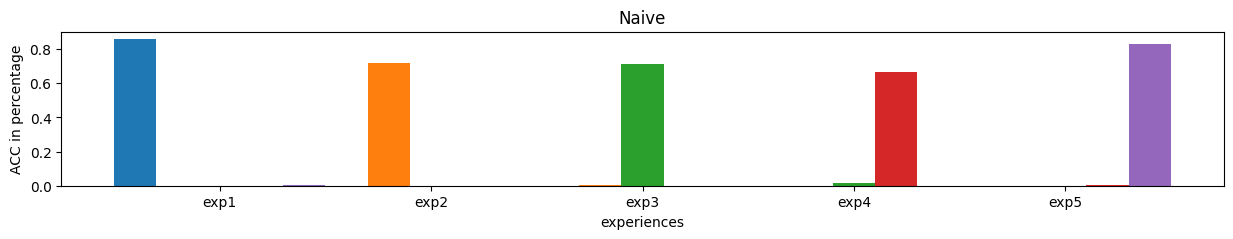

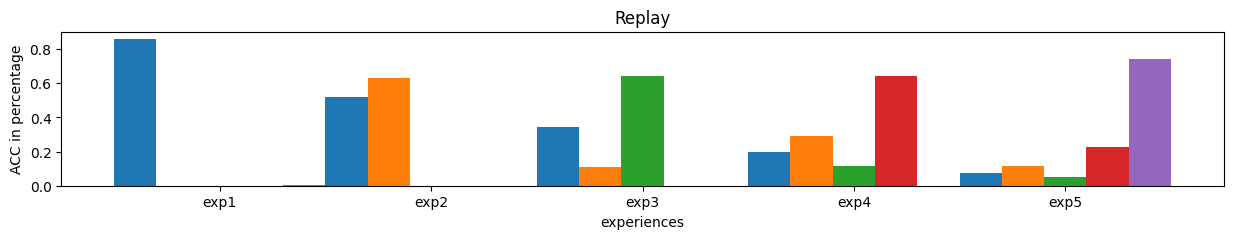

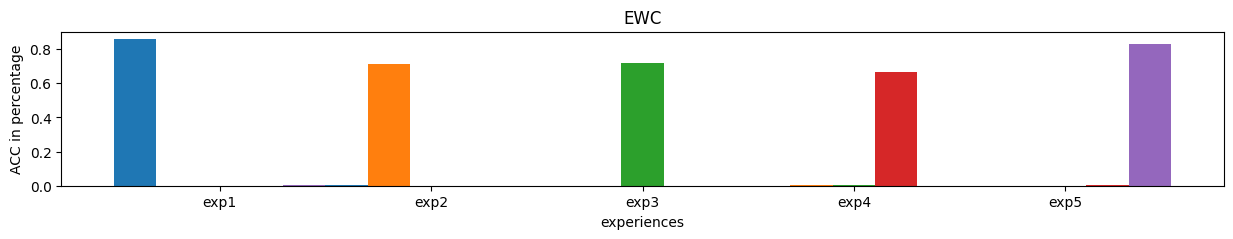

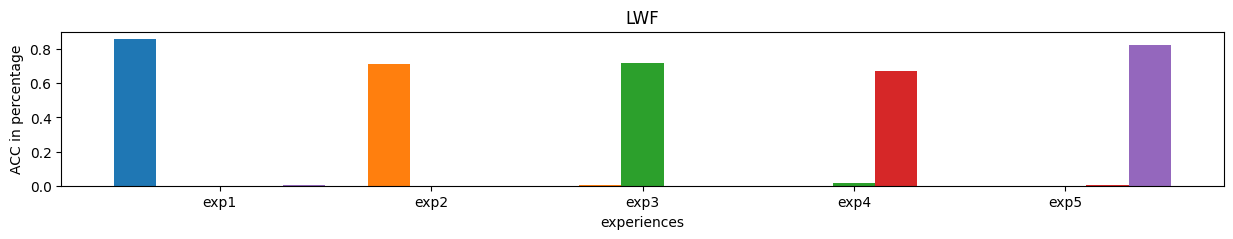

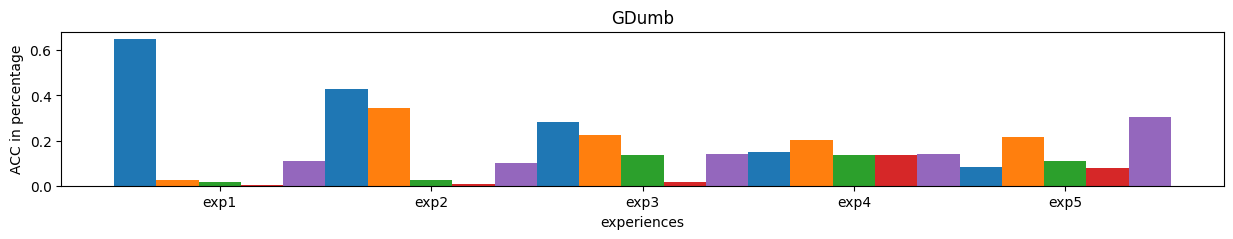

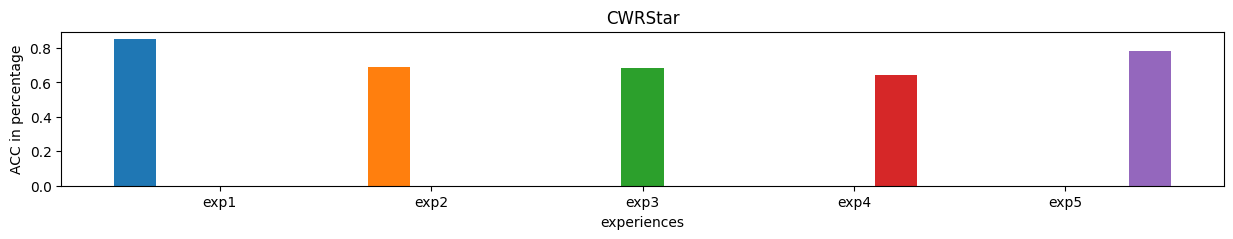

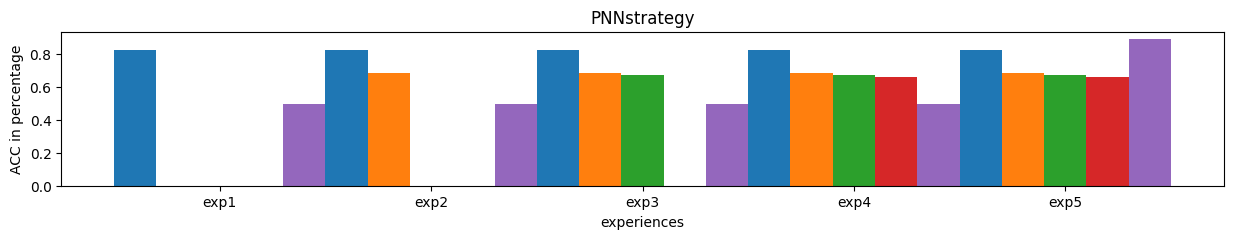

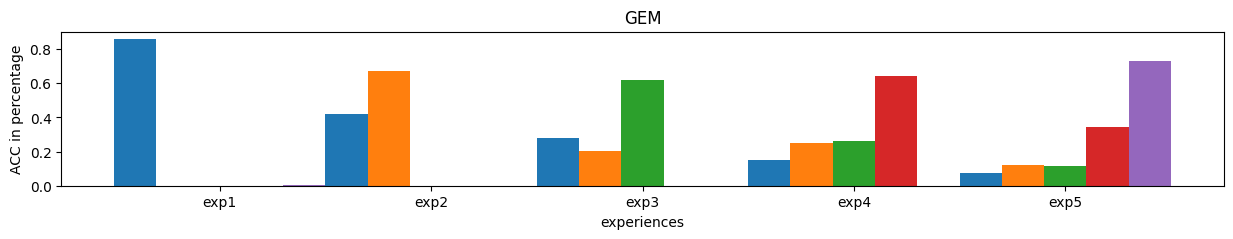

In [12]:
# data
x = np.array([1, 2, 3, 4, 5])
y1 = np.array([0.8590 ,0.0010 ,0.0005 ,0.     ,0.0000])
y2 = np.array([0.0005 ,0.7200 ,0.0030 ,0.0010 ,0.0000])
y3 = np.array([0.     ,0.     ,0.7150 ,0.0185 ,0.0000])
y4 = np.array([0.     ,0.     ,0.     ,0.6635 ,0.0030])
y5 = np.array([0.0015 ,0.     ,0.     ,0.     ,0.8290])


fig = plt.figure(figsize=(15, 2))
# plot bars
width = 0.2
plt.bar(x - 2*width, y1, width=width,)
plt.bar(x - width, y2, width=width,)
plt.bar(x, y3, width=width,)
plt.bar(x + width, y4, width=width,)
plt.bar(x + 2*width, y5, width=width,)
plt.xlabel('experiences')
plt.ylabel('ACC in percentage')
plt.title('Naive')
plt.xticks(x, ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'])
plt.show()

# data
x = np.array([1, 2, 3, 4, 5])
y1 = np.array([0.8590, 0.5215, 0.3450, 0.1985, 0.0720])
y2 = np.array([0.0005, 0.6295, 0.1070, 0.2910, 0.1150])
y3 = np.array([0.0000, 0.0000, 0.6435, 0.1180, 0.0500])
y4 = np.array([0.0000, 0.0000, 0.0000, 0.6440, 0.2250])
y5 = np.array([0.0015, 0.0000, 0.0000, 0.0000, 0.7445])

fig = plt.figure(figsize=(15, 2))
# plot bars
width = 0.2
plt.bar(x - 2*width, y1, width=width,)
plt.bar(x - width, y2, width=width,)
plt.bar(x, y3, width=width,)
plt.bar(x + width, y4, width=width,)
plt.bar(x + 2*width, y5, width=width,)
plt.xlabel('experiences')
plt.ylabel('ACC in percentage')
plt.title('Replay')
plt.xticks(x, ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'])
plt.show()

# data
x = np.array([1, 2, 3, 4, 5])
y1 = np.array([0.8590, 0.0015, 0.0005, 0.0000, 0.0000])
y2 = np.array([0.0005, 0.7115, 0.0005, 0.0015, 0.0000])
y3 = np.array([0.0000, 0.0000, 0.7200, 0.0065, 0.0000])
y4 = np.array([0.0000, 0.0000, 0.0000, 0.6645, 0.0030])
y5 = np.array([0.0015, 0.0000, 0.0000, 0.0000, 0.8275])

fig = plt.figure(figsize=(15, 2))
# plot bars
width = 0.2
plt.bar(x - 2*width, y1, width=width,)
plt.bar(x - width, y2, width=width,)
plt.bar(x, y3, width=width,)
plt.bar(x + width, y4, width=width,)
plt.bar(x + 2*width, y5, width=width,)
plt.xlabel('experiences')
plt.ylabel('ACC in percentage')
plt.title('EWC')
plt.xticks(x, ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'])
plt.show()

# data
x = np.array([1, 2, 3, 4, 5])
y1 = np.array([0.8590, 0.0005, 0.0005, 0.0000, 0.0000])
y2 = np.array([0.0005, 0.7120, 0.0025, 0.0010, 0.0000])
y3 = np.array([0.0000, 0.0000, 0.7170, 0.0185, 0.0000])
y4 = np.array([0.0000, 0.0000, 0.0000, 0.6690, 0.0060])
y5 = np.array([0.0015, 0.0000, 0.0000, 0.0000, 0.8255])

fig = plt.figure(figsize=(15, 2))
# plot bars
width = 0.2
plt.bar(x - 2*width, y1, width=width,)
plt.bar(x - width, y2, width=width,)
plt.bar(x, y3, width=width,)
plt.bar(x + width, y4, width=width,)
plt.bar(x + 2*width, y5, width=width,)
plt.xlabel('experiences')
plt.ylabel('ACC in percentage')
plt.title('LWF')
plt.xticks(x, ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'])
plt.show()

# data
x = np.array([1, 2, 3, 4, 5])
y1 = np.array([0.6495, 0.4290, 0.2830, 0.1475, 0.0810])
y2 = np.array([0.0235, 0.3450, 0.2235, 0.2030, 0.2140])
y3 = np.array([0.0160, 0.0235, 0.1370, 0.1345, 0.1100])
y4 = np.array([0.0015, 0.0055, 0.0150, 0.1345, 0.0800])
y5 = np.array([0.1075, 0.1025, 0.1395, 0.1400, 0.3045])


fig = plt.figure(figsize=(15, 2))
# plot bars
width = 0.2
plt.bar(x - 2*width, y1, width=width,)
plt.bar(x - width, y2, width=width,)
plt.bar(x, y3, width=width,)
plt.bar(x + width, y4, width=width,)
plt.bar(x + 2*width, y5, width=width,)
plt.xlabel('experiences')
plt.ylabel('ACC in percentage')
plt.title('GDumb')
plt.xticks(x, ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'])
plt.show()

# data
x = np.array([1, 2, 3, 4, 5])
y1 = np.array([0.8520, 0.0000, 0.0000, 0.0000, 0.0000])
y2 = np.array([0.0000, 0.6900, 0.0000, 0.0000, 0.0000])
y3 = np.array([0.0000, 0.0000, 0.6830, 0.0000, 0.0000])
y4 = np.array([0.0000, 0.0000, 0.0000, 0.6460, 0.0000])
y5 = np.array([0.0000, 0.0000, 0.0000, 0.0000, 0.7820])

fig = plt.figure(figsize=(15, 2))
# plot bars
width = 0.2
plt.bar(x - 2*width, y1, width=width,)
plt.bar(x - width, y2, width=width,)
plt.bar(x, y3, width=width,)
plt.bar(x + width, y4, width=width,)
plt.bar(x + 2*width, y5, width=width,)
plt.xlabel('experiences')
plt.ylabel('ACC in percentage')
plt.title('CWRStar')
plt.xticks(x, ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'])
plt.show()

# data
x = np.array([1, 2, 3, 4, 5])
y1 = np.array([0.8250, 0.8250, 0.8250, 0.8250, 0.8250])
y2 = np.array([0.0000, 0.6875, 0.6875, 0.6875, 0.6875])
y3 = np.array([0.0000, 0.0000, 0.6770, 0.6770, 0.6770])
y4 = np.array([0.0000, 0.0000, 0.0000, 0.6590, 0.6590])
y5 = np.array([0.5000, 0.5000, 0.5000, 0.5000, 0.8930])


fig = plt.figure(figsize=(15, 2))
# plot bars
width = 0.2
plt.bar(x - 2*width, y1, width=width,)
plt.bar(x - width, y2, width=width,)
plt.bar(x, y3, width=width,)
plt.bar(x + width, y4, width=width,)
plt.bar(x + 2*width, y5, width=width,)
plt.xlabel('experiences')
plt.ylabel('ACC in percentage')
plt.title('PNNstrategy')
plt.xticks(x, ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'])
plt.show()

# data
x = np.array([1, 2, 3, 4, 5])
y1 = np.array([0.8590, 0.4180, 0.2775, 0.1515, 0.0740])
y2 = np.array([0.0005, 0.6705, 0.2030, 0.2505, 0.1220])
y3 = np.array([0.0000, 0.0000, 0.6210, 0.2600, 0.1130])
y4 = np.array([0.0000, 0.0000, 0.0000, 0.6405, 0.3420])
y5 = np.array([0.0015, 0.0000, 0.0000, 0.0000, 0.7295])

fig = plt.figure(figsize=(15, 2))
# plot bars
width = 0.2
plt.bar(x - 2*width, y1, width=width,)
plt.bar(x - width, y2, width=width,)
plt.bar(x, y3, width=width,)
plt.bar(x + width, y4, width=width,)
plt.bar(x + 2*width, y5, width=width,)
plt.xlabel('experiences')
plt.ylabel('ACC in percentage')
plt.title('GEM')
plt.xticks(x, ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'])

plt.show()

**Naive:**
Here when a new experience comes we just train the new one. Then we have catastrophic forgetting. In some cases, we are seeing there is backward transfer but accuracy is not so much significant in these cases. Also, we can see too much plasticity here.

**Replay:**
While we are using past samples in the new experience training procedure it deals with catastrophic forgetting. As we see although the ACC related to previous tasks decreases, the trained model doesn't forget completely the past tasks. here we do not have any forward or backward transfer. The model has more plasticity, it means we are learning new tasks in the right way.

**GDUMB: **
It is a bit similar to the replay strategy, there is catastrophic forgetting and the model is without plasticity. Not only it forgets past tasks, but also it can't learn new tasks as well. there is no backward transfer, but we can see a negligible forward transfer in some cases.

**LWF, CWRStar:**
There is catastrophic forgetting without any forward and backward transfer. here the plasticity is pretty high and models can acquire new knowledge easily.

**PNN: **
Here there is no catastrophic forgetting it means the model doesn't forget a previous task while training on the new task. There exists forward transfer but without any backward transfer. there is plasticity here, it means the model can acquire new knowledge and keep learning over time.

**GEM:**
As far as we are seeing we have catastrophic forgetting and no forward and backward transfer. but the model is good for learning new tasks which means we have plasticity in this strategy.

**FWT**

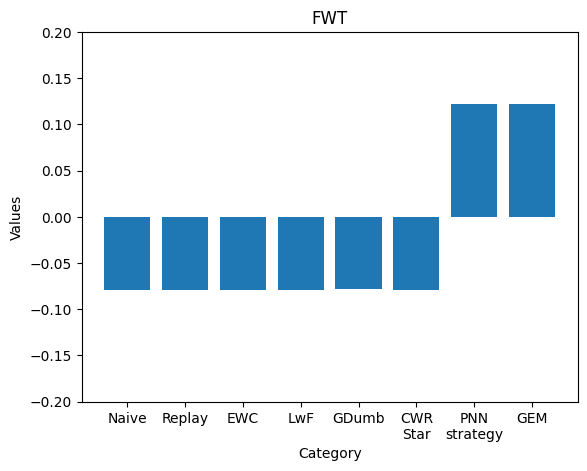

In [13]:
categories = ['Naive','Replay','EWC', 'LwF', 'GDumb','CWR\nStar','PNN\nstrategy','GEM']
numbers = np.array(FWT).flatten()
# Add labels to the plot
plt.title('FWT')
plt.xlabel('Category')
plt.ylabel('Values')
plt.ylim(-0.2, 0.2)
plt.bar(categories, numbers)
# Show the plot
plt.show()

FWT metric is a performance metric used to evaluate the ability of a continual learning model to transfer knowledge from previous tasks to new tasks. In all strategies except PNN, we have negative values, which means PNN can improve performance in the next experiences. Negative values mean model performs worse than a random model for the next experiences.

**BWT**

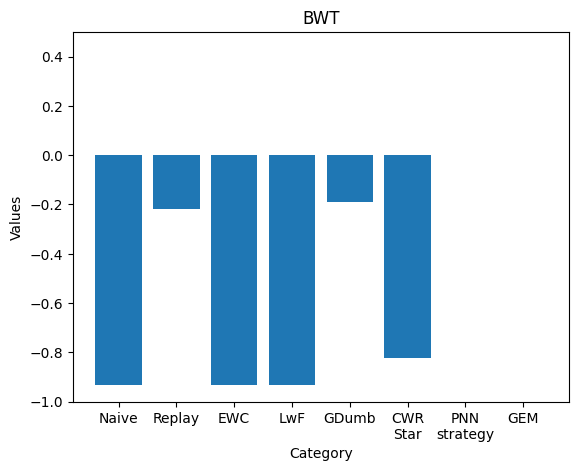

In [14]:
categories = ['Naive','Replay','EWC', 'LwF', 'GDumb','CWR\nStar','PNN\nstrategy','GEM']
numbers = np.array(BWT).flatten()
# Add labels to the plot
plt.title('BWT')
plt.xlabel('Category')
plt.ylabel('Values')
plt.bar(categories, numbers)
plt.ylim(-1, 0.5)
# Show the plot
plt.show()

BWT measures how the final model has improved or decreased the performances of previous experiences. Having negative values means forgetting. Here just for PNN, we have zero value and for the other methods, we have negative value. It is completely reasonable while we are comparing the ACC metric for these methods. Because just in the case of PNN we never forget the past.

**Conclusion**


As far as we compared above, the best model for this benchmark is PNN. The PNN strategy doesn't forget the past and keeps learning over time. It is quite reasonable because the main feature of PNN is the focus on the forward transfer and re-use of previously acquired representational power. We are getting good accuracy but it's quite inefficient. the reason is that as far as we are using big models significantly the parameter space grows and is very difficult to scale on longer sequences of experiences. While we are comparing the PNN model RAM and CPU usage and running time this is completely obvious the model is expensive in terms of computation. All in all, while we do have not any limitations on resources having more ACC and not forgetting past tasks, and keep learning over time is more important for us. After PNN, the other good methods are GDUMB and Replay. These strategies try to use past samples in new experiences and by doing so it helps to not forget the past. But as we see in these benchmarks the model had forgotten a bit the past knowledge. The next good method is GEM, which benefits both replay and regularization strategies. Here we have plasticity but we are forgetting the past experience by training on the new experience.

In [15]:
!pip freeze > requirements.txt